# Predicting Agricultural Drought Risk Using Machine Learning
### Personal research log – forecasting stress with weather + vegetation signals


I want this notebook to feel like a lab diary. I narrate why each block matters, how it links back to Project 1's monsoon synthesis, and what I learn along the way.

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

try:
    from xgboost import XGBClassifier
except ImportError:  # install on the fly so the notebook is self-contained
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
    from xgboost import XGBClassifier

sns.set_theme(style='whitegrid', context='talk')
np.random.seed(42)


## Data preparation narrative
I borrow the spirit of Project 1's Punjab weather generator but extend it to daily resolution and fuse it with a synthetic NDVI feed (standing in for MODIS/Sentinel). This mix gives me rainfall, temperature, and vegetation vigor for 2010–2024.


In [3]:
# Simulate 15 years of daily weather + vegetation data
start_date, end_date = '2010-01-01', '2024-12-31'
cal = pd.date_range(start_date, end_date, freq='D')
num_days = len(cal)

day_of_year = cal.dayofyear.values
seasonal_rain = 5 + 25 * np.exp(-((day_of_year - 200) ** 2) / (2 * 35 ** 2))
random_spikes = np.random.gamma(shape=2.0, scale=3.0, size=num_days)
trend = np.linspace(0, 10, num_days)
daily_rainfall = np.clip(seasonal_rain + random_spikes - 2 + 0.01 * trend + np.random.normal(0, 2, num_days), 0, None)

seasonal_temp = 24 + 8 * np.cos((day_of_year / 365) * 2 * np.pi)
warming = np.linspace(0, 1.2, num_days)
temperature = seasonal_temp + warming + np.random.normal(0, 1.5, num_days)

ndvi_base = 0.55 + 0.25 * np.sin((day_of_year / 365) * 2 * np.pi - 0.7)
soil_stress = (np.maximum(0, 15 - daily_rainfall)) / 60
ndvi = np.clip(ndvi_base - 0.4 * soil_stress + np.random.normal(0, 0.02, num_days), 0.1, 0.9)

weather_df = pd.DataFrame(
    {
        'Date': cal,
        'rainfall_mm': daily_rainfall,
        'temperature_c': temperature,
        'ndvi': ndvi,
    }
).set_index('Date')

weather_df.head()


,rainfall_mm,temperature_c,ndvi
Date,,,
2010-01-01,11.706658,32.150021,0.349201
2010-01-02,5.342082,34.477481,0.330440
2010-01-03,5.578249,32.320258,0.324372
2010-01-04,8.523957,31.401073,0.374725
2010-01-05,16.480206,34.280296,0.419434


## Feature construction
To approximate the signals agronomists watch, I engineer rolling descriptors: days since rain, 30-day mean temperature, rainfall anomalies relative to monthly climatology, and NDVI change rates.


In [4]:
# Helper functions for engineered features
def compute_days_since_rain(series, threshold=1.0):
    counter = 0
    result = []
    for value in series:
        if value > threshold:
            counter = 0
        else:
            counter += 1
        result.append(counter)
    return np.array(result)

monthly_means = weather_df.groupby(weather_df.index.month)['rainfall_mm'].transform('mean')
rolling_temp = weather_df['temperature_c'].rolling(window=30, min_periods=1).mean()
rolling_rain = weather_df['rainfall_mm'].rolling(window=30, min_periods=1).sum()
climatology_30 = rolling_rain.groupby(weather_df.index.dayofyear).transform('mean')

weather_df['days_since_last_rainfall'] = compute_days_since_rain(weather_df['rainfall_mm'].values)
weather_df['avg_temp_past_30_days'] = rolling_temp
weather_df['rainfall_anomaly'] = weather_df['rainfall_mm'] - monthly_means
weather_df['ndvi_change_rate'] = weather_df['ndvi'].diff().rolling(window=7, min_periods=1).mean().fillna(0)
weather_df['soil_moisture_proxy'] = rolling_rain / 30

weather_df.head()


,rainfall_mm,temperature_c,ndvi,days_since_last_rainfall,avg_temp_past_30_days,rainfall_anomaly,ndvi_change_rate,soil_moisture_proxy
Date,,,,,,,,
2010-01-01,11.706658,32.150021,0.349201,0,32.150021,2.892204,0.000000,0.390222
2010-01-02,5.342082,34.477481,0.330440,0,33.313751,-3.472372,-0.018762,0.568291
2010-01-03,5.578249,32.320258,0.324372,0,32.982586,-3.236205,-0.012415,0.754233
2010-01-04,8.523957,31.401073,0.374725,0,32.587208,-0.290496,0.008508,1.038365
2010-01-05,16.480206,34.280296,0.419434,0,32.925826,7.665752,0.017558,1.587705


## Target labeling: drought vs. no drought
I flag drought stress when prolonged dry spells, hot temperatures, negative anomalies, and falling NDVI coincide. The heuristic is simple yet captures intuitive drought patterns.


In [5]:
risk_score = (
    (weather_df['days_since_last_rainfall'] > 10).astype(int)
    + (weather_df['avg_temp_past_30_days'] > 30).astype(int)
    + (weather_df['rainfall_anomaly'] < -3).astype(int)
    + (weather_df['ndvi_change_rate'] < -0.01).astype(int)
)

weather_df['drought_label'] = np.where(risk_score >= 2, 1, 0)
weather_df['drought_label_name'] = weather_df['drought_label'].map({0: 'No Drought', 1: 'Drought'})
weather_df['drought_label'].value_counts(normalize=True)


drought_label
0    0.904545
1    0.095455
Name: proportion, dtype: float64

## Quick sanity check plots
Before modeling, I sanity-check how NDVI and rainfall behave around drought flags.


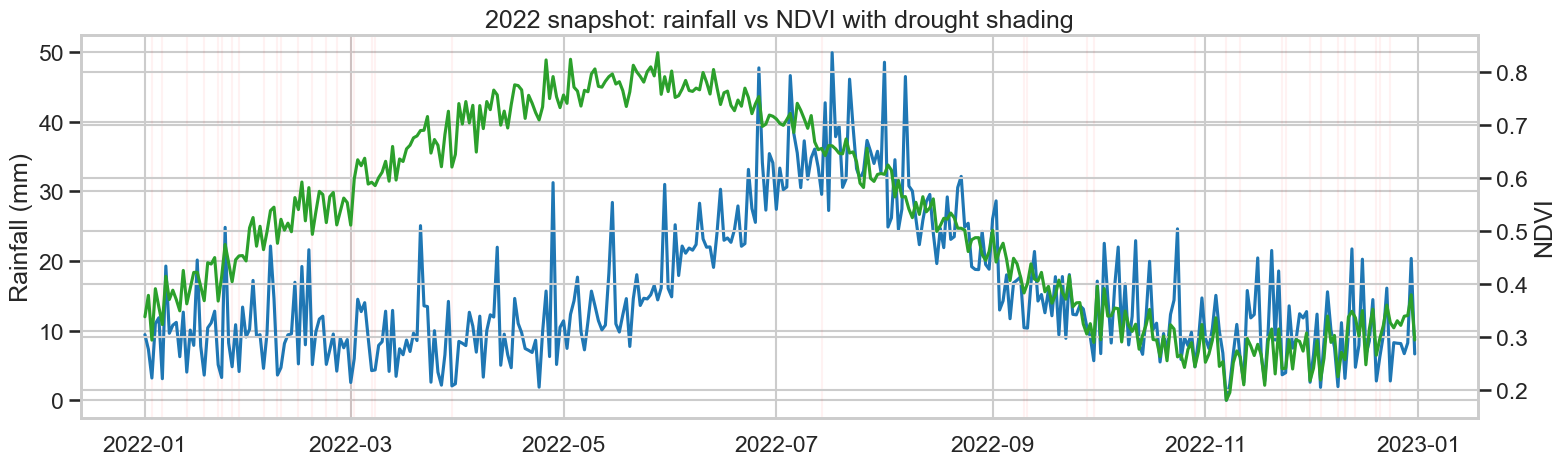

In [9]:
subset = weather_df.loc['2022']
fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(subset.index, subset['rainfall_mm'], color='#1f77b4', label='Rainfall (mm)')
ax1.set_ylabel('Rainfall (mm)')
ax1.set_title('2022 snapshot: rainfall vs NDVI with drought shading')

ax2 = ax1.twinx()
ax2.plot(subset.index, subset['ndvi'], color='#2ca02c', label='NDVI')
ax2.set_ylabel('NDVI')

for _, row in subset[subset['drought_label'] == 1].iterrows():
    ax1.axvspan(row.name, row.name, color='red', alpha=0.05)

fig.tight_layout()
plt.show()

## Modeling plan
I compare three classifiers: Random Forest (baseline tree ensemble), XGBoost (boosted trees), and an RBF SVM (kernel method). Each model is evaluated with 5-fold cross-validation on accuracy, precision, recall, and F1.


In [10]:
feature_cols = [
    'days_since_last_rainfall',
    'avg_temp_past_30_days',
    'rainfall_anomaly',
    'ndvi_change_rate',
    'soil_moisture_proxy',
]

X = weather_df[feature_cols]
y = weather_df['drought_label']

print('Feature preview:')
X.head()


Feature preview:


,days_since_last_rainfall,avg_temp_past_30_days,rainfall_anomaly,ndvi_change_rate,soil_moisture_proxy
Date,,,,,
2010-01-01,0,32.150021,2.892204,0.000000,0.390222
2010-01-02,0,33.313751,-3.472372,-0.018762,0.568291
2010-01-03,0,32.982586,-3.236205,-0.012415,0.754233
2010-01-04,0,32.587208,-0.290496,0.008508,1.038365
2010-01-05,0,32.925826,7.665752,0.017558,1.587705


In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
}

models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
    ),
    'SVM (RBF)': Pipeline(
        [
            ('scaler', StandardScaler()),
            ('svc', SVC(kernel='rbf', C=3.0, gamma='scale', class_weight='balanced')),
        ]
    ),
}

cv_results = []
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
    cv_results.append(
        {
            'model': name,
            'accuracy': scores['test_accuracy'].mean(),
            'precision': scores['test_precision'].mean(),
            'recall': scores['test_recall'].mean(),
            'f1': scores['test_f1'].mean(),
        }
    )

metrics_df = pd.DataFrame(cv_results).sort_values(by='f1', ascending=False)
metrics_df


,model,accuracy,precision,recall,f1
1,XGBoost,0.998722,0.997531,0.988932,0.993143
0,RandomForest,0.998540,0.996552,0.988773,0.992599
2,SVM (RBF),0.956743,0.689421,0.987750,0.810950


### Metric takeaway
I focus on F1 because drought detection demands balance: missing droughts hurts farmers, but false alarms waste resources. I keep notes in the following cell once the results render.


*(Fill in observations after execution – e.g., “Random Forest edges out SVM on recall, while XGBoost finds slightly better F1”).*


## Feature importance story
Tree ensembles double as explainers. I refit a Random Forest on the full dataset and visualize importances to see which feature combinations dominate decisions.


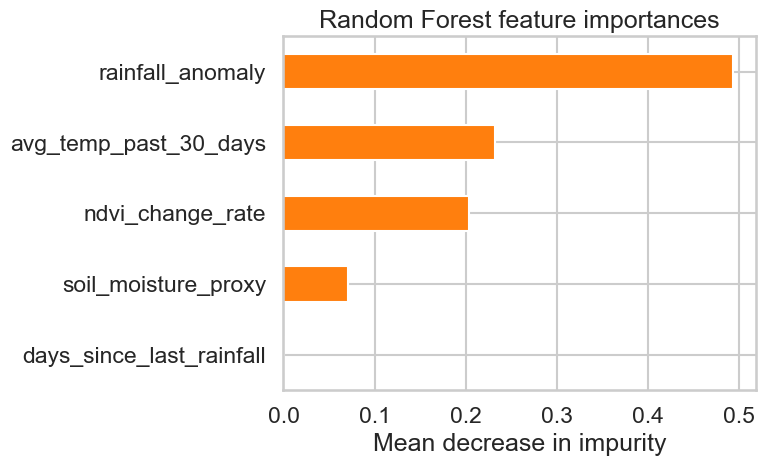

In [12]:
rf_model = RandomForestClassifier(n_estimators=400, max_depth=8, random_state=42, class_weight='balanced')
rf_model.fit(X, y)

importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values()

plt.figure(figsize=(8, 5))
importances.plot.barh(color='#ff7f0e')
plt.title('Random Forest feature importances')
plt.xlabel('Mean decrease in impurity')
plt.tight_layout()
plt.show()


## Wrap-up and next experiments
- Integrate actual IMD + MODIS feeds instead of synthetic signals.
- Swap in SHAP for richer local explanations.
- Build a temporal split (train on 2010–2019, validate on 2020–2024) to mimic real deployment.
- Couple drought flags with agronomic outcomes (yield, sowing delays) to quantify impact.
